# Environment Setup

In [ ]:
# Install required packages with specific versions
!pip install torch==2.1.0 torchtext==0.16.0 torchvision==0.16.0
!pip install numpy==1.23.5 pandas==2.0.1 matplotlib==3.7.1 tqdm==4.66.3
!pip install tensorflow==2.12.0
!pip install spacy
!python -m spacy download fr_core_news_sm

  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wrapt-1.14.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.35-cp310-cp310-manylinux2014_x86_64.whl.metadata (983 bytes)
  Using cached jax-0.4.34-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.34-cp310-cp310-manylinux2014_x86_64.whl.metadata (983 bytes)
  Using cached jax-0.4.31-py3-non

In [ ]:
# Need to restart runtime after installation
import os
os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from tqdm.notebook import trange, tqdm
import time

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check if GPU is available
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Set device
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CUDA available: True
GPU: Tesla T4
Using device: cuda:0


In [ ]:
# Define the hyperparameters
learning_rate = 1e-3
nepochs = 2
batch_size = 128
max_len = 2
hidden_size = 2
num_layers = 1

In [ ]:
# Adapt corpus path to your drive hierarchy
# corpus_path = '/content/drive/MyDrive/Colab Notebooks/web-text-analytics/cleaned_lemonde_corpus.txt'
corpus_path = '/content/drive/MyDrive/lemonde_corpus.txt'

# Dataset Initialization
This class is designed for language modeling tasks using PyTorch and torchtext.
It tokenizes the corpus, builds a vocabulary, and creates sequences of tokens for training recurrent neural network (RNNs); here LSTM and GRU.

In the context of this notebook, this class is tailored for the Le Monde corpus, which is used for experiments comparing the performance of LSTM and GRU models with different input representations (one-hot encoding and Word2Vec).


In [ ]:
# Custom Dataset for LeMonde corpus
class LemondeDataset(Dataset):
    """
    A custom dataset class for processing text data from a given file, tokenizing it, and creating sequences for language modeling tasks.

    Attributes:
        sequence_length (int): The length of each sequence.
        data (torch.Tensor): The tensor containing token indices.
        sequences (list): A list of sequences created from the token indices.
        targets (list): A list of target sequences corresponding to the input sequences.

    Methods:
        __len__(): Returns the number of sequences in the dataset.
        __getitem__(idx): Returns the sequence and target at the specified index.

    Args:
        file_path (str): The path to the text file containing the corpus.
        vocab (dict): A dictionary mapping tokens to their corresponding indices.
        tokenizer (callable): A function or callable object that tokenizes the text.
        sequence_length (int): The length of each sequence to be created.
    """
    def __init__(self, file_path, vocab, tokenizer, sequence_length):
        self.sequence_length = sequence_length

        # Read the corpus
        print("Reading corpus from:", file_path)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        print(f"Corpus length: {len(text)} characters")

        # Tokenize the entire text
        print("Tokenizing text...")
        tokens = tokenizer(text)
        print(f"Number of tokens: {len(tokens)}")

        # Convert tokens to indices
        print("Converting tokens to indices...")
        self.data = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)

        # Create sequences and targets
        print("Creating sequences...")
        self.sequences = []
        self.targets = []

        for i in range(0, len(self.data) - sequence_length):
            sequence = self.data[i:i + sequence_length]
            target = self.data[i + 1:i + sequence_length + 1]
            self.sequences.append(sequence)
            self.targets.append(target)

        print(f"Created {len(self.sequences)} sequences")

    def __len__(self):
        """Returns the number of sequences in the object."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """Retrieve the sequence and target at the specified index."""
        return self.sequences[idx], self.targets[idx]

The following code defines a function `create_french_tokenizer` that creates and returns a French tokenizer function using the `spaCy` library. The tokenizer function processes large text inputs by splitting them into chunks and tokenizing each chunk. The `tqdm` library is used to display a progress bar during the tokenization process. If the required `spaCy` French language model is not installed, the function attempts to install it automatically. This tokenizer is useful for efficiently handling and tokenizing large French text datasets in the context of this notebook.

In [ ]:
import spacy
from tqdm import tqdm

def create_french_tokenizer():
    """Create and return a French tokenizer function"""
    try:
        # Load spaCy model with disabled components for speed
        nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

        def tokenize_text(text, chunk_size=900000):
            tokens = []
            # Split text into chunks
            chunks = [text[i:i + chunk_size]
                     for i in range(0, len(text), chunk_size)]

            print(f"Processing {len(chunks)} chunks...")

            # Process each chunk
            for chunk in tqdm(chunks):
                doc = nlp(chunk)
                chunk_tokens = [token.text for token in doc]
                tokens.extend(chunk_tokens)

            return tokens

        return tokenize_text

    except OSError:
        print("Installing French language model...")
        import os
        os.system('python -m spacy download fr_core_news_sm')
        nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])
        return create_french_tokenizer()

In [ ]:
# Tokenizer and Vocabulary Creation
print("Initializing tokenizer...")
tokenizer = create_french_tokenizer()

# Read corpus for vocab creation
print(f"Reading corpus from {corpus_path}...")
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

def yield_tokens(text):
    yield tokenizer(text)

# Build vocabulary
print("Building vocabulary...")
vocab = build_vocab_from_iterator(
    yield_tokens(corpus),
    min_freq=2,
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])
print(f"Vocabulary size: {len(vocab)}")

Initializing tokenizer...
Reading corpus from /content/drive/MyDrive/lemonde_corpus.txt...
Building vocabulary...
Processing 1 chunks...


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]

Vocabulary size: 4309


In [ ]:
# Dataset Creation and Splitting
print("Creating dataset...")
dataset = LemondeDataset(corpus_path, vocab, tokenizer, max_len)

print("Splitting dataset...")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Creating dataset...
Reading corpus from: /content/drive/MyDrive/lemonde_corpus.txt
Corpus length: 233150 characters
Tokenizing text...
Processing 1 chunks...


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Number of tokens: 40700
Converting tokens to indices...
Creating sequences...
Created 40698 sequences
Splitting dataset...


# Generate Text + Perplexity

In [ ]:
def generate_text(model, vocab, tokenizer, seed_text, max_length=20):
    """
    Generate text using the trained model (LSTM or GRU)

    Args:
        model: The trained model (LSTM or GRU)
        vocab: Vocabulary object
        tokenizer: Tokenizer function
        seed_text: Initial text to start generation
        max_length: Maximum number of tokens to generate

    Returns:
        str: The generated text
    """
    model.eval()
    device = next(model.parameters()).device

    # Tokenize seed text
    tokens = tokenizer(seed_text)
    current_sequence = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)

    # Initialize hidden states
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)

    # Initialize memory cell only for LSTM
    memory = torch.zeros(num_layers, 1, hidden_size, device=device) if isinstance(model, LSTM) else None

    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_length):
            # Prepare input
            input_sequence = current_sequence[-1:].unsqueeze(0).to(device)

            # Get model prediction based on model type
            if isinstance(model, LSTM):
                output, hidden, memory = model(input_sequence, hidden, memory)
            else:  # GRU case
                output, hidden = model(input_sequence, hidden)

            # Get probabilities and sample next token
            probs = F.softmax(output.squeeze(), dim=-1)
            next_token_idx = torch.multinomial(probs, 1).item()

            # Append to generated sequence
            current_sequence = torch.cat([current_sequence, torch.tensor([next_token_idx])])

            # Get the actual token
            for token, idx in vocab.get_stoi().items():
                if idx == next_token_idx:
                    generated_tokens.append(token)
                    break

    return seed_text + ' ' + ' '.join(generated_tokens)

In [ ]:
def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    return torch.exp(torch.tensor(loss)).item()

---
# Experiment 1: Investigate the performance using LSTM vs. GRU

## LSTM
LSTM stands for Long Short-Term Memory, and it is a type of recurrent neural network (RNN) architecture that is commonly used in natural language processing, speech recognition, and other sequence modeling tasks.

Unlike a traditional RNN, which has a simple structure of input, hidden state, and output, an LSTM has a more complex structure with additional memory cells and gates that allow it to selectively remember or forget information from previous time steps.

> For more info, click on this [Medium Article](https://medium.com/@anishnama20/understanding-lstm-architecture-pros-and-cons-and-implementation-3e0cca194094).

In [ ]:
# LSTM Model Definition
class LSTM(nn.Module):
    """
    A Long Short-Term Memory (LSTM) neural network module.

    Args:
        num_emb (int): The size of the input vocabulary.
        output_size (int): The size of the output layer.
        num_layers (int, optional): The number of LSTM layers. Default is 1.
        hidden_size (int, optional): The number of features in the hidden state. Default is 128.

    Attributes:
        embedding (nn.Embedding): Embedding layer that converts input indices to dense vectors.
        lstm (nn.LSTM): LSTM layer(s) for processing sequences.
        fc_out (nn.Linear): Fully connected layer that maps LSTM outputs to the desired output size.

    Methods:
        forward(input_seq, hidden_in, mem_in):
            Performs a forward pass of the LSTM network.

            Args:
                input_seq (Tensor): Input sequence tensor of shape (batch_size, seq_length).
                hidden_in (Tensor): Initial hidden state tensor of shape (num_layers, batch_size, hidden_size).
                mem_in (Tensor): Initial cell state tensor of shape (num_layers, batch_size, hidden_size).

            Returns:
                Tuple[Tensor, Tensor, Tensor]: Output tensor of shape (batch_size, seq_length, output_size),
                                               hidden state tensor of shape (num_layers, batch_size, hidden_size),
                                               and cell state tensor of shape (num_layers, batch_size, hidden_size).
    """
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=0.5)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_seq)
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        return self.fc_out(output), hidden_out, mem_out

### LSTM Init

In [ ]:
import glob

# File path for the checkpoint directory
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/web-text-analytics/"
checkpoint_pattern = f"{checkpoint_dir}/checkpoint_epoch_*.pth"

# Find the latest checkpoint
checkpoint_files = glob.glob(checkpoint_pattern)
if checkpoint_files:
    # Sort by epoch number extracted from the file name
    checkpoint_files.sort(key=lambda x: int(x.split('_epoch_')[-1].split('.pth')[0]))
    checkpoint_path = checkpoint_files[-1]  # Get the latest checkpoint file
    print(f"Checkpoint found: {checkpoint_path}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Initialize model with the same architecture
    model = LSTM(num_emb=len(vocab),
                 output_size=len(vocab),
                 num_layers=num_layers,
                 hidden_size=hidden_size).to(device)

    # Load saved model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Optionally, load epoch and losses to resume training
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    perplexities = checkpoint['perplexities']

    print(f"Model and optimizer loaded. Resuming from epoch {start_epoch}.")
else:
    # No checkpoint found, initializing a new model
    print("No checkpoint found, starting training from scratch.")
    model = LSTM(num_emb=len(vocab),
                 output_size=len(vocab),
                 num_layers=num_layers,
                 hidden_size=hidden_size).to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    start_epoch = 0  # Start from the first epoch
    train_losses = []
    test_losses = []
    perplexities = []
    print("No checkpoint found, starting training from scratch.")

# Print model summary
print("\nModel Architecture:")
print(model)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Loss function
loss_fn = nn.CrossEntropyLoss()


No checkpoint found, starting training from scratch.
No checkpoint found, starting training from scratch.

Model Architecture:
LSTM(
  (embedding): Embedding(4309, 2)
  (lstm): LSTM(2, 2, batch_first=True, dropout=0.5)
  (fc_out): Linear(in_features=2, out_features=4309, bias=True)
)

Total parameters: 21,593


### LSTM Training

In [ ]:
# Training and Validation Setup for LSTM
# Training Loop
start_time = time.time()

# Initialize the progress bar with the correct range
epoch_bar = trange(start_epoch, nepochs, desc="Training Progress")

for epoch in epoch_bar:
    # Training phase
    model.train()
    train_loss = 0
    train_steps = 0

    batch_bar = tqdm(train_loader,
                    desc=f"Epoch {epoch+1}/{nepochs}",
                    leave=False,
                    ncols=100,
                    mininterval=1.0)

    for sequences, targets in batch_bar:
        sequences = sequences.to(device)
        targets = targets.to(device)
        bs = sequences.shape[0]
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass
        output, hidden, memory = model(sequences, hidden, memory)
        output = output.view(-1, len(vocab))
        targets = targets.view(-1)

        # Calculate loss
        loss = loss_fn(output, targets)
        train_loss += loss.item()
        train_steps += 1

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        batch_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / train_steps
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    test_loss = 0
    test_steps = 0

    with torch.no_grad():
        for sequences, targets in tqdm(test_loader, desc="Validation", leave=False):
            sequences = sequences.to(device)
            targets = targets.to(device)
            bs = sequences.shape[0]
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)

            output, hidden, memory = model(sequences, hidden, memory)
            output = output.view(-1, len(vocab))
            targets = targets.view(-1)

            loss = loss_fn(output, targets)
            test_loss += loss.item()
            test_steps += 1

    avg_test_loss = test_loss / test_steps
    test_losses.append(avg_test_loss)

    # Calculate perplexity
    perplexity = calculate_perplexity(avg_test_loss)
    perplexities.append(perplexity)

    # Update progress bar
    epoch_bar.set_postfix(
        train_loss=f"{avg_train_loss:.4f}",
        test_loss=f"{avg_test_loss:.4f}",
        perplexity=f"{perplexity:.2f}"
    )

    # Generate sample text every few epochs
    if (epoch + 1) % 2 == 0:
        sample_text = generate_text(model, vocab, tokenizer, "Le président", max_length=20)
        print(f"\nSample text generation: {sample_text}\n")

    if (epoch + 1) % 5 == 0 or epoch == nepochs - 1:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'perplexities': perplexities
        }, f"checkpoint_epoch_{epoch+1}.pth")
        print(f"Checkpoint saved for epoch {epoch+1}")



Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2:  73%|███████████████████████████▏         | 187/255 [00:04<00:01, 63.17it/s, loss=8.1550]
                                                                                                    
Validation:  47%|████▋     | 30/64 [00:00<00:00, 291.71it/s]
                                                            
Epoch 2/2:  78%|████████████████████████████▋        | 198/255 [00:02<00:00, 94.14it/s, loss=7.6313]
                                                                                                    
Validation:  55%|█████▍    | 35/64 [00:00<00:00, 344.80it/s]
                                                            

Processing 1 chunks...



100%|██████████| 1/1 [00:00<00:00, 128.23it/s]



Sample text generation: Le président poids colonial écrit université hama orlando isabelle directeur retraite réflexives lancée opération aline brandissant rivière fondamentale caf minent mode questions

Checkpoint saved for epoch 2


### Visualise the results (LSTM)


Training completed in 63.17 seconds


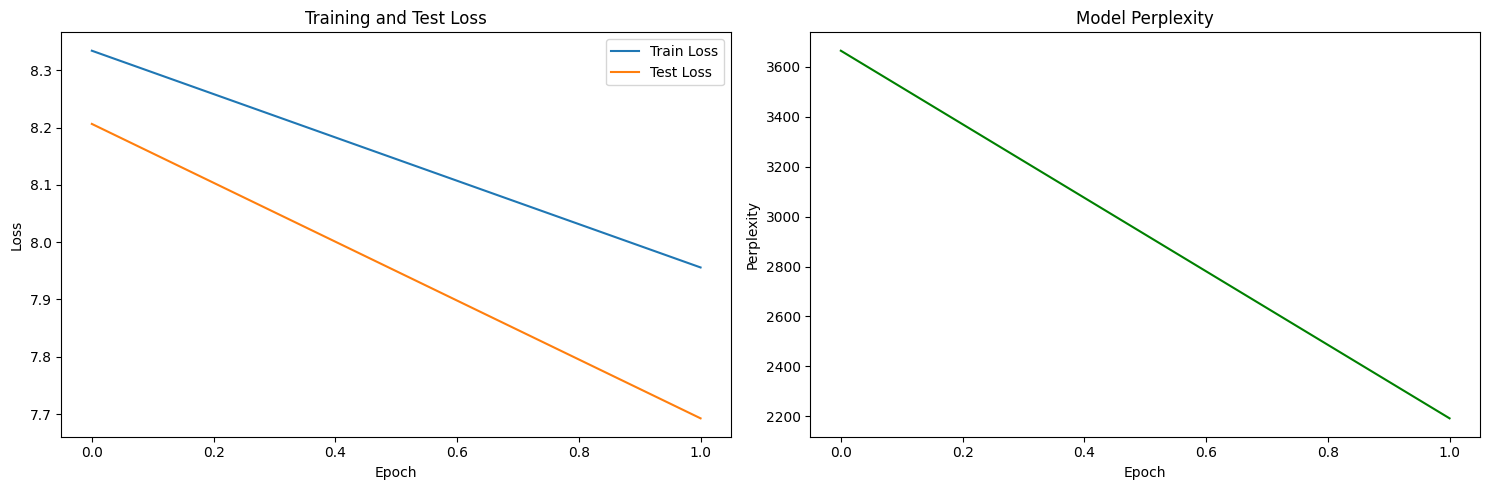

In [ ]:
# Training Summary and Visualization
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot perplexity
plt.subplot(1, 2, 2)
plt.plot(perplexities, color='green')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Model Perplexity')
plt.tight_layout()
plt.show()

## GRU

In [ ]:
# GRU Model Definition
class GRU(nn.Module):
    def __init__(self, num_emb, output_size, num_layers, hidden_size, dropout=0.2):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(num_emb, hidden_size)

        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # Embedding shape: batch_size x sequence_length x hidden_size
        embedding = self.embedding(x)

        # GRU output shape: batch_size x sequence_length x hidden_size
        output, hidden = self.gru(embedding, hidden)

        # Reshape output for linear layer
        output = output.contiguous().view(-1, self.hidden_size)

        # Linear layer shape: batch_size*sequence_length x output_size
        output = self.fc(output)

        return output, hidden

### GRU Init

In [ ]:
# Initialize GRU Model
print("Initializing GRU model...")
gru_model = GRU(num_emb=len(vocab),
                output_size=len(vocab),
                num_layers=num_layers,
                hidden_size=hidden_size).to(device)

# Print model summary
print("\nGRU Model Architecture:")
print(gru_model)

# Calculate total parameters
gru_params = sum(p.numel() for p in gru_model.parameters())
print(f"\nTotal GRU parameters: {gru_params:,}")

# Initialize optimizer and loss function for GRU
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
gru_loss_fn = nn.CrossEntropyLoss()

Initializing GRU model...

GRU Model Architecture:
GRU(
  (embedding): Embedding(4309, 2)
  (gru): GRU(2, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=4309, bias=True)
)

Total GRU parameters: 21,581


### GRU Training

In [ ]:
# Training and Validation Setup for GRU
# Initialize lists to store metrics
gru_train_losses = []
gru_test_losses = []
gru_perplexities = []

# GRU Training Loop
print("\nStarting GRU Training...")
gru_start_time = time.time()
gru_epoch_bar = trange(nepochs, desc="GRU Training Progress")

for epoch in gru_epoch_bar:
    # Training phase
    gru_model.train()
    train_loss = 0
    train_steps = 0

    batch_bar = tqdm(train_loader,
                    desc=f"Epoch {epoch+1}/{nepochs}",
                    leave=False,
                    ncols=100,
                    mininterval=1.0)

    for sequences, targets in batch_bar:
        sequences = sequences.to(device)
        targets = targets.to(device)
        bs = sequences.shape[0]
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass
        output, hidden = gru_model(sequences, hidden)
        output = output.view(-1, len(vocab))
        targets = targets.view(-1)

        # Calculate loss
        loss = gru_loss_fn(output, targets)
        train_loss += loss.item()
        train_steps += 1

        # Backward pass
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()

        # Update progress bar
        batch_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / train_steps
    gru_train_losses.append(avg_train_loss)

    # Validation Phase
    gru_model.eval()
    test_loss = 0
    test_steps = 0

    with torch.no_grad():
        for sequences, targets in tqdm(test_loader, desc="Validation", leave=False):
            sequences = sequences.to(device)
            targets = targets.to(device)
            bs = sequences.shape[0]
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)

            output, hidden = gru_model(sequences, hidden)
            output = output.view(-1, len(vocab))
            targets = targets.view(-1)

            loss = gru_loss_fn(output, targets)
            test_loss += loss.item()
            test_steps += 1

    avg_test_loss = test_loss / test_steps
    gru_test_losses.append(avg_test_loss)

    # Calculate perplexity
    perplexity = calculate_perplexity(avg_test_loss)
    gru_perplexities.append(perplexity)

    # Update progress bar
    gru_epoch_bar.set_postfix(
        train_loss=f"{avg_train_loss:.4f}",
        test_loss=f"{avg_test_loss:.4f}",
        perplexity=f"{perplexity:.2f}"
    )

    # Generate sample text every few epochs
    if (epoch + 1) % 2 == 0:
        sample_text = generate_text(gru_model, vocab, tokenizer, "Le président", max_length=20)
        print(f"\nGRU Sample text generation: {sample_text}\n")

gru_training_time = time.time() - gru_start_time


Starting GRU Training...


GRU Training Progress:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2:  79%|█████████████████████████████▏       | 201/255 [00:02<00:00, 95.83it/s, loss=8.1914]
                                                                                                    
Validation:  70%|███████   | 45/64 [00:00<00:00, 447.44it/s]
                                                            
Epoch 2/2:  80%|████████████████████████████▊       | 204/255 [00:02<00:00, 102.01it/s, loss=7.4298]
                                                                                                    
Validation:  59%|█████▉    | 38/64 [00:00<00:00, 378.52it/s]
                                                            

Processing 1 chunks...



100%|██████████| 1/1 [00:00<00:00, 147.88it/s]



GRU Sample text generation: Le président secours intervenus carburant piste enseigné projets un haut gerland printemps wydad de lukasz sy morkov méthode appelle majeures nos historiquement



## Visualise the results (LSTM vsGRU)

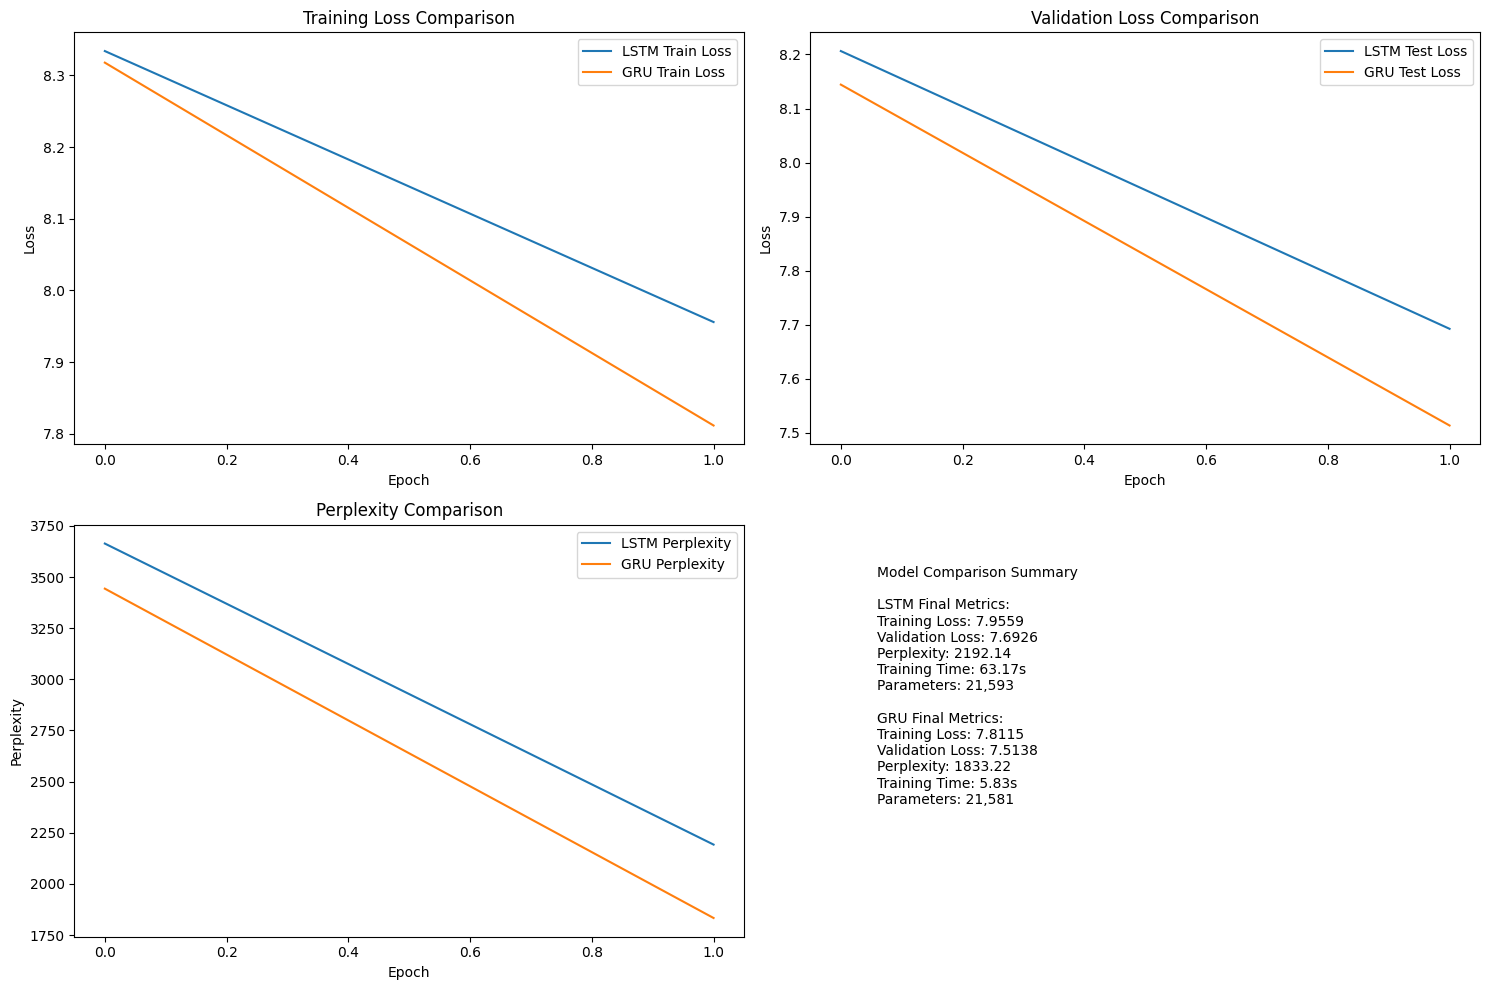

In [ ]:
# Comparison Visualization
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='LSTM Train Loss')
plt.plot(gru_train_losses, label='GRU Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Plot validation losses
plt.subplot(2, 2, 2)
plt.plot(test_losses, label='LSTM Test Loss')
plt.plot(gru_test_losses, label='GRU Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# Plot perplexities
plt.subplot(2, 2, 3)
plt.plot(perplexities, label='LSTM Perplexity')
plt.plot(gru_perplexities, label='GRU Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity Comparison')
plt.legend()

# Add comparison metrics
plt.subplot(2, 2, 4)
plt.axis('off')
info_text = (
    f'Model Comparison Summary\n\n'
    f'LSTM Final Metrics:\n'
    f'Training Loss: {train_losses[-1]:.4f}\n'
    f'Validation Loss: {test_losses[-1]:.4f}\n'
    f'Perplexity: {perplexities[-1]:.2f}\n'
    f'Training Time: {training_time:.2f}s\n'
    f'Parameters: {total_params:,}\n\n'
    f'GRU Final Metrics:\n'
    f'Training Loss: {gru_train_losses[-1]:.4f}\n'
    f'Validation Loss: {gru_test_losses[-1]:.4f}\n'
    f'Perplexity: {gru_perplexities[-1]:.2f}\n'
    f'Training Time: {gru_training_time:.2f}s\n'
    f'Parameters: {gru_params:,}'
)
plt.text(0.1, 0.9, info_text, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

In [ ]:
# Print final comparison
print("\nFinal Comparison Summary:")
print("\nLSTM Model:")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {test_losses[-1]:.4f}")
print(f"Final Perplexity: {perplexities[-1]:.2f}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Number of Parameters: {total_params:,}")

print("\nGRU Model:")
print(f"Final Training Loss: {gru_train_losses[-1]:.4f}")
print(f"Final Validation Loss: {gru_test_losses[-1]:.4f}")
print(f"Final Perplexity: {gru_perplexities[-1]:.2f}")
print(f"Training Time: {gru_training_time:.2f} seconds")
print(f"Number of Parameters: {gru_params:,}")


Final Comparison Summary:

LSTM Model:
Final Training Loss: 7.9559
Final Validation Loss: 7.6926
Final Perplexity: 2192.14
Training Time: 63.17 seconds
Number of Parameters: 21,593

GRU Model:
Final Training Loss: 7.8115
Final Validation Loss: 7.5138
Final Perplexity: 1833.22
Training Time: 5.83 seconds
Number of Parameters: 21,581


---
# **Experiment 2**: Investigate the performance using 1-hot encoding and Word2Vec as input.

## One-hot Encode

In [ ]:
class LSTMOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMOneHot, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # One-hot input will be vocab_size dimensional
        self.lstm = nn.LSTM(vocab_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden, memory):
        # Convert input to one-hot
        x_one_hot = torch.zeros(x.size(0), x.size(1), self.vocab_size, device=x.device)
        x_one_hot.scatter_(2, x.unsqueeze(-1), 1)

        output, (hidden, memory) = self.lstm(x_one_hot, (hidden, memory))
        output = self.fc(output)
        return output, hidden, memory

In [ ]:
class GRUOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2):
        super(GRUOneHot, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # One-hot input will be vocab_size dimensional
        self.gru = nn.GRU(vocab_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # Convert input to one-hot
        x_one_hot = torch.zeros(x.size(0), x.size(1), self.vocab_size, device=x.device)
        x_one_hot.scatter_(2, x.unsqueeze(-1), 1)

        output, hidden = self.gru(x_one_hot, hidden)
        output = self.fc(output)
        return output, hidden

## Word2Vec

In [ ]:
class LSTMWord2Vec(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, w2v_model, vocab, dropout=0.2):
        super(LSTMWord2Vec, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # Create embedding matrix from Word2Vec
        embedding_dim = w2v_model.vector_size
        embedding_matrix = self.create_embedding_matrix(w2v_model, vocab, embedding_dim)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def create_embedding_matrix(self, w2v_model, vocab, embedding_dim):
        embedding_matrix = torch.zeros(len(vocab), embedding_dim)
        for token, idx in vocab.get_stoi().items():
            if token in w2v_model.wv:
                embedding_matrix[idx] = torch.tensor(w2v_model.wv[token])
        return embedding_matrix

    def forward(self, x, hidden, memory):
        embedded = self.embedding(x)
        output, (hidden, memory) = self.lstm(embedded, (hidden, memory))
        output = self.fc(output)
        return output, hidden, memory

In [ ]:
class GRUWord2Vec(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, w2v_model, vocab, dropout=0.2):
        super(GRUWord2Vec, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # Create embedding matrix from Word2Vec
        embedding_dim = w2v_model.vector_size
        embedding_matrix = self.create_embedding_matrix(w2v_model, vocab, embedding_dim)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def create_embedding_matrix(self, w2v_model, vocab, embedding_dim):
        embedding_matrix = torch.zeros(len(vocab), embedding_dim)
        for token, idx in vocab.get_stoi().items():
            if token in w2v_model.wv:
                embedding_matrix[idx] = torch.tensor(w2v_model.wv[token])
        return embedding_matrix

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded, hidden)
        output = self.fc(output)
        return output, hidden

## Training Functions

In [ ]:
# Train Word2Vec model
def train_word2vec(tokenized_corpus, embedding_dim=100):
    """Train Word2Vec model on the corpus"""
    w2v_model = Word2Vec(sentences=tokenized_corpus,
                        vector_size=embedding_dim,
                        window=5,
                        min_count=2,
                        workers=4)
    return w2v_model

In [ ]:
# Training function for all models
def train_model(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device, model_type):
    """Generic training function for both types of models"""
    train_losses = []
    test_losses = []
    perplexities = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_steps = 0

        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            targets = targets.to(device)
            batch_size = sequences.size(0)

            # Initialize hidden (and memory for LSTM)
            hidden = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)

            if isinstance(model, (LSTMOneHot, LSTMWord2Vec)):
                memory = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
                output, _, _ = model(sequences, hidden, memory)
            else:  # GRU models
                output, _ = model(sequences, hidden)

            loss = loss_fn(output.view(-1, model.vocab_size), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_steps += 1

        avg_train_loss = train_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        test_loss = 0
        test_steps = 0

        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                batch_size = sequences.size(0)

                hidden = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)

                if isinstance(model, (LSTMOneHot, LSTMWord2Vec)):
                    memory = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
                    output, _, _ = model(sequences, hidden, memory)
                else:  # GRU models
                    output, _ = model(sequences, hidden)

                loss = loss_fn(output.view(-1, model.vocab_size), targets.view(-1))
                test_loss += loss.item()
                test_steps += 1

        avg_test_loss = test_loss / test_steps
        test_losses.append(avg_test_loss)

        # Calculate perplexity
        perplexity = torch.exp(torch.tensor(avg_test_loss)).item()
        perplexities.append(perplexity)

        print(f'Epoch {epoch+1}/{num_epochs} | {model_type}')
        print(f'Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Perplexity: {perplexity:.2f}')

    return train_losses, test_losses, perplexities

## Run Experiments

In [ ]:
# Initialize and train all models
import os
def run_experiments(train_loader, test_loader, vocab, device, config):
    """Run experiments with different models and embeddings"""
    results = {}
    drive_path = '/content/drive/MyDrive/Colab Notebooks/web-text-analytics/'

    # Create directory if it doesn't exist
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    # Prepare Word2Vec model
    w2v_model = train_word2vec(config['tokenized_corpus'], config['embedding_dim'])

    # Initialize models
    models = {
        'LSTM_OneHot': LSTMOneHot(len(vocab), config['hidden_size'], config['num_layers']),
        'GRU_OneHot': GRUOneHot(len(vocab), config['hidden_size'], config['num_layers']),
        'LSTM_W2V': LSTMWord2Vec(len(vocab), config['hidden_size'], config['num_layers'], w2v_model, vocab),
        'GRU_W2V': GRUWord2Vec(len(vocab), config['hidden_size'], config['num_layers'], w2v_model, vocab)
    }

    # Train each model
    for name, model in models.items():
        model_path = os.path.join(drive_path, f'model_{name}.pt')

        if os.path.exists(model_path):
            print(f"\nLoading {name} from {model_path}")
            checkpoint = torch.load(model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            results[name] = {
                'train_losses': checkpoint['train_losses'],
                'test_losses': checkpoint['test_losses'],
                'perplexities': checkpoint['perplexities']
            }
        else:
            print(f"\nTraining {name}")
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
            loss_fn = nn.CrossEntropyLoss()

            train_losses, test_losses, perplexities = train_model(
                model, train_loader, test_loader, optimizer, loss_fn,
                config['num_epochs'], device, name
            )

            results[name] = {
                'train_losses': train_losses,
                'test_losses': test_losses,
                'perplexities': perplexities
            }

            # Save model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'test_losses': test_losses,
                'perplexities': perplexities
            }, model_path)

    return results

In [ ]:
# Visualization of results
def plot_comparison(results):
    """Plot comparison of all models"""
    plt.figure(figsize=(15, 10))

    # Plot training losses
    plt.subplot(2, 2, 1)
    for name, metrics in results.items():
        plt.plot(metrics['train_losses'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    # Plot validation losses
    plt.subplot(2, 2, 2)
    for name, metrics in results.items():
        plt.plot(metrics['test_losses'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()

    # Plot perplexities
    plt.subplot(2, 2, 3)
    for name, metrics in results.items():
        plt.plot(metrics['perplexities'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity Comparison')
    plt.legend()

    # Summary metrics table
    plt.subplot(2, 2, 4)
    plt.axis('off')
    summary_text = "Final Metrics Summary\n\n"
    for name, metrics in results.items():
        summary_text += f"{name}:\n"
        summary_text += f"Final Train Loss: {metrics['train_losses'][-1]:.4f}\n"
        summary_text += f"Final Valid Loss: {metrics['test_losses'][-1]:.4f}\n"
        summary_text += f"Final Perplexity: {metrics['perplexities'][-1]:.2f}\n\n"
    plt.text(0.1, 0.9, summary_text, fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.show()

Reading and tokenizing corpus...
Processing 1 chunks...


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]



Configuration:
Hidden Size: 2
Number of Layers: 1
Embedding Dimension: 100
Learning Rate: 0.001
Number of Epochs: 2
Vocabulary Size: 4309
Device: cuda:0

Starting experiments with 4 models:
1. LSTM with One-Hot Encoding
2. GRU with One-Hot Encoding
3. LSTM with Word2Vec
4. GRU with Word2Vec

Training LSTM_OneHot
Epoch 1/2 | LSTM_OneHot
Train Loss: 8.2767 | Test Loss: 8.0816 | Perplexity: 3234.45
Epoch 2/2 | LSTM_OneHot
Train Loss: 7.8060 | Test Loss: 7.5508 | Perplexity: 1902.17

Training GRU_OneHot
Epoch 1/2 | GRU_OneHot
Train Loss: 8.2645 | Test Loss: 8.0238 | Perplexity: 3052.83
Epoch 2/2 | GRU_OneHot
Train Loss: 7.6774 | Test Loss: 7.3802 | Perplexity: 1603.95

Training LSTM_W2V
Epoch 1/2 | LSTM_W2V
Train Loss: 8.2470 | Test Loss: 8.0408 | Perplexity: 3105.01
Epoch 2/2 | LSTM_W2V
Train Loss: 7.7426 | Test Loss: 7.5041 | Perplexity: 1815.52

Training GRU_W2V
Epoch 1/2 | GRU_W2V
Train Loss: 8.3203 | Test Loss: 8.0496 | Perplexity: 3132.42
Epoch 2/2 | GRU_W2V
Train Loss: 7.7599 | Tes

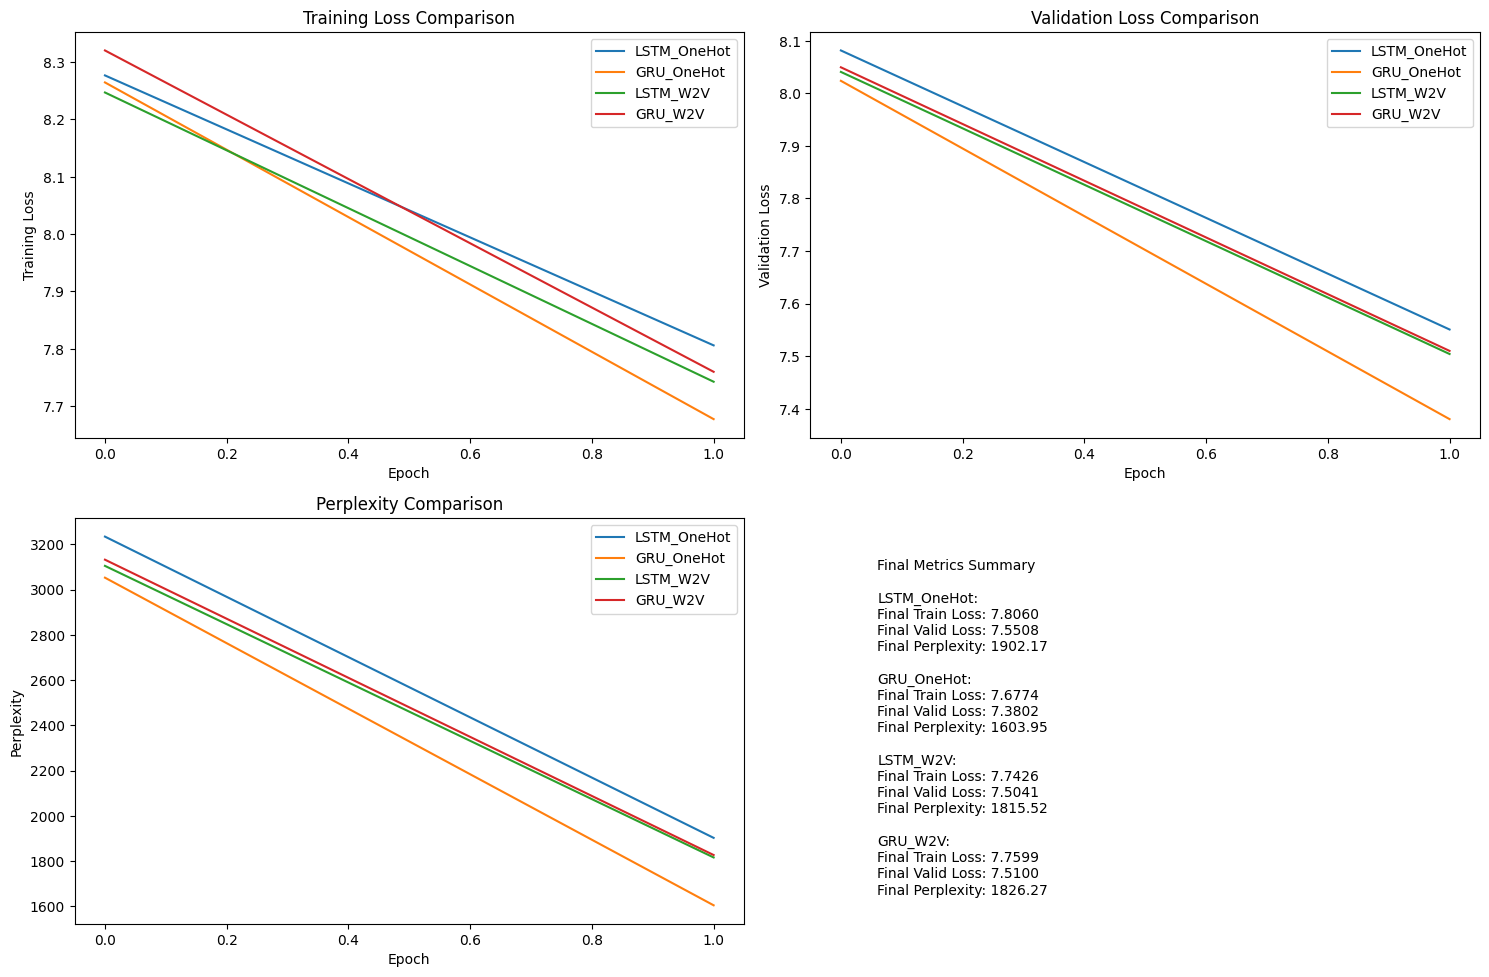


Final Results Summary:

LSTM_OneHot:
Final Training Loss: 7.8060
Final Validation Loss: 7.5508
Final Perplexity: 1902.17

GRU_OneHot:
Final Training Loss: 7.6774
Final Validation Loss: 7.3802
Final Perplexity: 1603.95

LSTM_W2V:
Final Training Loss: 7.7426
Final Validation Loss: 7.5041
Final Perplexity: 1815.52

GRU_W2V:
Final Training Loss: 7.7599
Final Validation Loss: 7.5100
Final Perplexity: 1826.27


In [ ]:
# Step 1: Prepare tokenized corpus using existing structure
print("Reading and tokenizing corpus...")
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

# Use the same tokenizer and structure as before
def yield_tokens(text):
    yield tokenizer(text)

tokenized_corpus = list(yield_tokens(corpus))  # Convert generator to list for Word2Vec

# Step 2: Configuration using existing parameters
config = {
    'hidden_size': hidden_size,      # from existing setup
    'num_layers': num_layers,        # from existing setup
    'embedding_dim': 100,            # Word2Vec embedding dimension
    'learning_rate': learning_rate,  # from existing setup
    'num_epochs': nepochs,           # from existing setup
    'tokenized_corpus': tokenized_corpus
}

# Print configuration for verification
print("\nConfiguration:")
print(f"Hidden Size: {config['hidden_size']}")
print(f"Number of Layers: {config['num_layers']}")
print(f"Embedding Dimension: {config['embedding_dim']}")
print(f"Learning Rate: {config['learning_rate']}")
print(f"Number of Epochs: {config['num_epochs']}")
print(f"Vocabulary Size: {len(vocab)}")
print(f"Device: {device}")

# Step 3: Run experiments
print("\nStarting experiments with 4 models:")
print("1. LSTM with One-Hot Encoding")
print("2. GRU with One-Hot Encoding")
print("3. LSTM with Word2Vec")
print("4. GRU with Word2Vec")

results = run_experiments(train_loader, test_loader, vocab, device, config)

# Step 4: Plot and save results
plot_comparison(results)

# Print final comparison
print("\nFinal Results Summary:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Final Training Loss: {metrics['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {metrics['test_losses'][-1]:.4f}")
    print(f"Final Perplexity: {metrics['perplexities'][-1]:.2f}")